In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as op
from scipy.stats import norm

# Denoising Function

In [13]:
def denoise(v,var_x,var_z,epsilon):

    term1 = (1-epsilon)*norm.pdf(v,0,np.sqrt(var_z))
    term2 = epsilon*norm.pdf(v,0,np.sqrt(var_x+var_z))
    xW = var_x/(var_x+var_z)*v # Wiener filter
    added_term = term1+term2
    div_term = np.divide(term2,added_term)
    xhat = np.multiply(div_term, xW) # denoised version, x(t+1)

    # empirical derivative
    Delta = 0.0000000001 # perturbation
    term1_d = (1-epsilon)*norm.pdf((v+Delta),0,np.sqrt(var_z))
    term2_d = epsilon*norm.pdf((v+Delta),0,np.sqrt(var_x+var_z))
    xW2 = var_x/(var_x+var_z)*(v+Delta) # Wiener filter

    added_term = term1_d+term2_d
    mul_term = np.multiply(xW2,term2_d)
    xhat2 = np.divide(mul_term,added_term)
    d = (xhat2-xhat)/Delta
    return xhat,d

# Defining Variables

In [14]:
# y = np.sqrt(gamma)*A*x + z
# solve for x given y,A
N = 2000 # length of signal
M = 500 # number of measurements
delta = M/N # measurement rate
gamma=20 # SNR


In [15]:
# signal parameters
var_x=1
epsilon = 0.05 # probability of nonzero signal

# AMP parameters
max_iter = 40 # number of AMP iterations
lamda = 0.3 # damping parameter can't use 'lambda' since that is a python keyword


In [16]:
# generate signal
# f_X(x) = epsilon*N(0,1)+(1-epsilon)*delta(x)
x = (np.random.rand(N,1)<epsilon)*np.random.randn(N,1) 

# matrix
A = 1/np.sqrt(M)*np.random.randn(M,N) # unit norm columns
print(A)
Atrans = np.transpose(A)# transpose of A

[[-0.03873432 -0.00297881  0.01059183 ... -0.12480901  0.06669316
  -0.0452748 ]
 [ 0.02913736  0.02898406 -0.02891789 ... -0.03582014  0.03826349
  -0.0047856 ]
 [-0.03474547  0.02977628 -0.07128241 ... -0.02202449  0.07124842
  -0.00144901]
 ...
 [ 0.03025343  0.08130361 -0.06130621 ...  0.01950154 -0.01186216
   0.04956357]
 [ 0.01654722 -0.03583972  0.00924568 ...  0.07072807  0.01721913
  -0.02770157]
 [ 0.02140179 -0.02776316  0.04583285 ... -0.00662029 -0.03072815
  -0.04118109]]


# Snippet of Signal

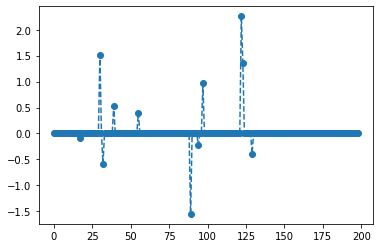

In [17]:
# Mark each data value and customize the linestyle:
plt.plot(x[1:200], marker = "o", linestyle = "--")
plt.show()

In [19]:
# measurements
# y = np.sqrt(gamma)*A*x + z
y = np.sqrt(gamma)*np.dot(A,x) + np.random.randn(M,1)# measurements

# normalize differently with gamma
y=y/np.sqrt(gamma)

# Plot with MSE vs Iterations

AMP error = [0.00986564]



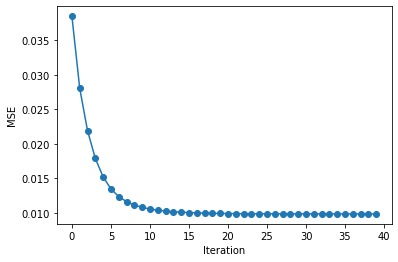

In [20]:
# AMP algorithm
# initialization
mse = np.zeros((max_iter,1)) # store mean square error
xt = np.zeros((N,1))# estimate of signal
dt = np.zeros((N,1))# derivative of denoiser
rt = np.zeros((M,1))# residual

for iter in range(0,max_iter):
    # update residual
    rt = y - np.dot(A,xt) + 1/delta*np.mean(dt)*rt
    # compute pseudo-data
    vt = xt + np.dot(Atrans,rt)
    # estimate scalar channel noise variance estimator is due to Montanari
    var_t = np.mean(rt**2)
    # denoising
    xt1,dt = denoise(vt,var_x,var_t,epsilon)
    # damping step
    xt=lamda*xt1+(1-lamda)*xt
    mse[iter] = np.mean((xt-x)**2)

## plot result
#figure
plt.plot(mse,'o-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
print('AMP error = {}\n'.format(min(mse)))


# Snippet of Denoised Signal

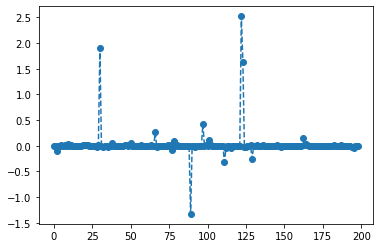

In [21]:
plt.plot(xt1[1:200], marker = "o", linestyle = "--")
plt.show()

# Plot with Varying MSE vs SNR values 

AMP error = 0.003995013693065403



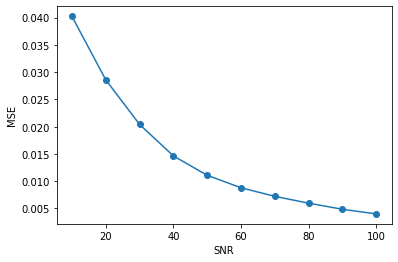

In [22]:
mse_snr = [] #np.zeros((max_iter,1)) # store mean square error
xt_1 = np.zeros((N,1))# estimate of signal
dt_1 = np.zeros((N,1))# derivative of denoiser
rt_1 = np.zeros((M,1))# residual

SNR=[10,20,30,40,50,60,70,80,90,100]

for snr in SNR:
    y = np.sqrt(snr)*np.dot(A,x) + np.random.randn(M,1)# measurements

    # normalize differently with gamma
    y=y/np.sqrt(snr)
    # update residual
    rt_1 = y - np.dot(A,xt_1) + 1/delta*np.mean(dt_1)*rt_1
    # compute pseudo-data
    vt = xt_1 + np.dot(Atrans,rt_1)
    # estimate scalar channel noise variance estimator is due to Montanari
    var_t = np.mean(rt_1**2)
    # denoising
    xt1,dt_1 = denoise(vt,var_x,var_t,epsilon)
    # damping step
    xt_1=lamda*xt1+(1-lamda)*xt_1
    mse_snr.append(np.mean((xt_1-x)**2))
    #np.append(mse_snr, np.mean((xt_1-x)**2) )

## plot result
#figure
plt.plot(SNR, mse_snr,'o-')
plt.xlabel('SNR')
plt.ylabel('MSE')
print('AMP error = {}\n'.format(min(mse_snr)))